In [1]:
from typing import Tuple, TypeVar
import numpy as np
from scipy import stats
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gpflow
from gpflow.utilities import print_summary
from utilities_dpp import (load_single_gene_normalized, create_data, load_data, load_single_gene, load_filtered_data, create_standard_mcmc, create_trcd_model, create_premRNA_model,
                       optimize_with_scipy_optimizer, optimize_premRNA, fit_rbf, predict_trcd,
                       plot_trcd_predict, plot_premRNA_predict, select_parameters, optimize_premRNA, init_hyperparameters)

gpflow.config.set_default_float(np.float64)  

Scalar = TypeVar("Scalar", tf.Tensor, float)
FullData = Tuple[tf.Tensor, tf.Tensor]
Observations = Tuple[tf.Tensor, tf.Tensor, tf.Tensor]

np.random.seed(100)
tf.random.set_seed(100)

## Load the data

In [2]:
data1 = pd.read_csv('LB_GP_TS.csv', sep=",")
data2 = pd.read_csv('Exon_intron_counts_data_normalizedbylibrarydepthonly_20200120.txt',sep=" ")
names_transcripts =  pd.read_csv('zygotic_tr_95_genes.csv', sep=";")

t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))
rep_no = 3
t = np.hstack((t0,t0,t0))[:,None]
t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))

## The gene we are interested in

In [3]:
'''
Gene and transcripts id
'''
gene_id = 'FBgn0000439'
tr_id = 'FBtr0081621'

In [4]:
data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id)

## New normalization

mRNA per cell: 242.76; mRNA per TS 19.36; embryo age 205. 

In [5]:
norm_m = 242.76
norm_p = 19.36
time_indexes = np.array([np.where(t == 190)[0],np.where(t == 205)[0],np.where(t == 220)[0]]).flatten()

In [6]:
data, observations, gene_id, data_p, observations_p = load_single_gene_normalized(gene_id, tr_id, time_indexes, norm_m, norm_p)

In [7]:
#data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id, time_indexes, norm_m, norm_p)
data_orig, observations_orig, gene_id_orig, data_p_orig, observations_p_orig = load_single_gene(gene_id, tr_id)

## Create and optimize model with fixed S = 1

In [8]:
#print_summary(trcd)

In [9]:
[l_init, var_init] = np.meshgrid(np.linspace(5.1, np.max(20.0), 10), np.linspace(0.1,  np.max(1.0), 10))
l_init = l_init.reshape(-1,1)
var_init = var_init.reshape(-1,1)

In [10]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data, initial_lengthscale, initial_variance, initial_S, transform_base=None)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
dict_parameters = select_parameters(dict_parameters,
                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=449.02725550776984
Step 10 loss=413.36847751624805


In [11]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │        value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  0.000436809 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │              │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  1           │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ TRCD.model.kernel.vari

predicted y failed, predicted f


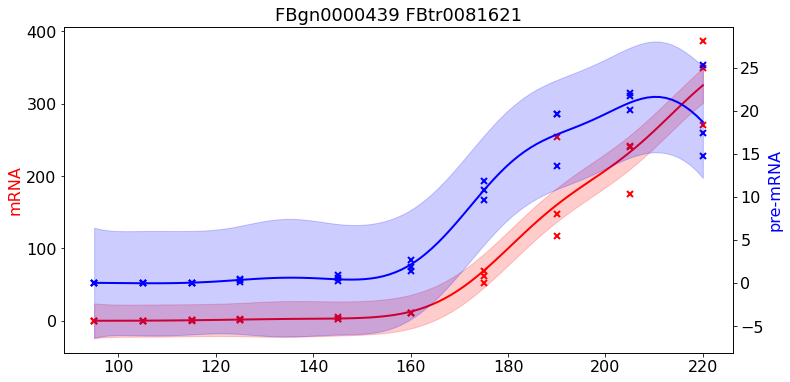

In [12]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations, variance_m, variance_p)

predicted y failed, predicted f


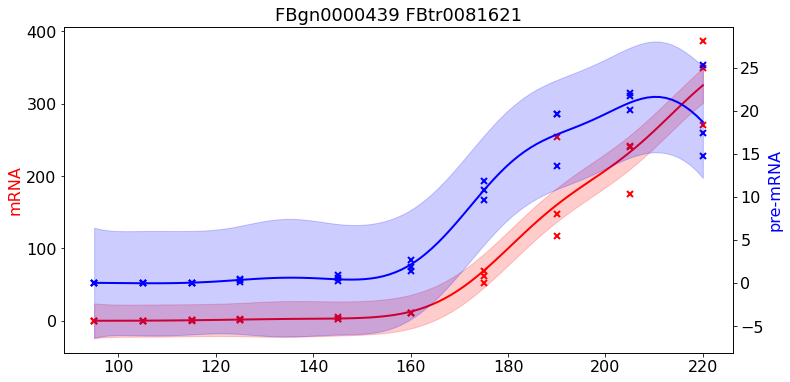

In [13]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations, variance_m, variance_p)

## Original data

In [14]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data_orig, initial_lengthscale, initial_variance, initial_S, transform_base=None)
dict_parameters = select_parameters(dict_parameters,
                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
#dict_parameters = select_parameters(dict_parameters,
 #                                   names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=165.8105826069594
Step 10 loss=144.29044033278103


In [15]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  0.0133386 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │            │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  0.245505  │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ TRCD.model.kernel.variance       │ Par

predicted y failed, predicted f


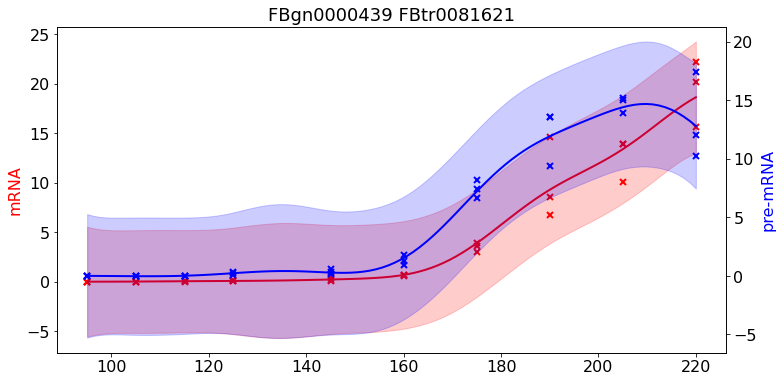

In [16]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations_orig, variance_m, variance_p)